# SGD Classifier - Linear SVC on Malware Image Data

### Import Libraries

In [1]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
import skimage.io 
import skimage.segmentation
import matplotlib.pyplot as plt
import seaborn as sns
import copy

In [2]:
!pip install memory_profiler
%load_ext memory_profiler

### Load Malicious and Benign File Lists into Pandas Dataframe

In [3]:
data = dict()
import pandas as pd

benign = pd.read_table('F:/test/Downloads/images_256x256/images_256x256/benign.txt', delimiter="\n", header=None)
benign.columns = ["filenm"]
benign['kind'] = 'benign'
malicious = pd.read_table('F:/test/Downloads/images_256x256/images_256x256/malicious.txt', delimiter="\n", header=None)
malicious.columns = ["filenm"]
malicious['kind'] = 'malicious'
df = benign.append(malicious)

### Create sample of 60,000 files (30K from each class) and Shuffle Data

In [22]:
bn_smp = benign.sample(n = 30000)
ml_smp = malicious.sample(n = 30000)
df_smp = bn_smp.append(ml_smp)

In [23]:
df_smp = df_smp.sample(frac=1).reset_index(drop=True)

In [24]:
df_smp.head(5)

,filenm,kind
0,00d0700117c9ce31a3e8ea3ebf7f791ff9a00303d98325...,malicious
1,007f527e97dc98e913a7e7d8dfb6a3b836ac9a790eb3cc...,malicious
2,quota-lib.npy,benign
3,04b857b1d1dfd050ca37d917150b3bfb5b66e0ff57f64f...,malicious
4,016f51b8492e88ab5eaa081608eb282acfa0e0ab24981d...,malicious


In [25]:
#Convert DF to list for training
data['label'] = []
data['filenam'] = []
data['label'] = df_smp['kind'].to_list()
data['filenam'] = df_smp['filenm'].to_list()

### Create Test Data Set

In [26]:
%%time
%%memit
bn_smp = benign.sample(n = 1500)
ml_smp = malicious.sample(n = 1500)
test_df = bn_smp.append(ml_smp)

peak memory: 1986.22 MiB, increment: 0.08 MiB
Wall time: 4 s


In [27]:
%%time
%%memit
test=dict()
test['label'] = test_df['kind'].to_list()
test['filenam'] = test_df['filenm'].to_list()
test['data'] = []
cnt = 0
for i in test['filenam']:
    i_data = np.load(f"F:/test/Downloads/images_256x256/images_256x256/{test['label'][cnt]}/{i}").astype('float32')
    test['data'].append(i_data[1024:])
    cnt += 1

peak memory: 2650.48 MiB, increment: 664.24 MiB
Wall time: 31.2 s


### Create Function to Define Batches for Incremental Learning

In [28]:
def batcherator(data, target, chunksize):
    for i in range(0, len(data), chunksize):
        yield data[i:i+chunksize], target[i:i+chunksize]

### Fit Standard Scaler on Training Data Set and transform Test Data Set

In [29]:
%%time
%%memit

gen = batcherator(data['filenam'], data['label'], 500)

scaler = StandardScaler()

for chunk_data, chunk_target in gen:
    ch_dt = []
    for count, i in enumerate(chunk_data, start = 0):
        i_data = np.load(f"F:/test/Downloads/images_256x256/images_256x256/{chunk_target[count]}/{i}").astype('float32')
        ch_dt.append(i_data[1024:])
    scaler.partial_fit(ch_dt)

peak memory: 3089.88 MiB, increment: 439.39 MiB
Wall time: 11min 25s


In [30]:
test['data'] = scaler.transform(test['data'])

### Train SGD Classifier using partial fit

In [31]:
%%time
%%memit
classifier = SGDClassifier(shuffle = True, loss="hinge", penalty="l2", alpha=0.0001, max_iter=3000, tol=None, verbose=0, learning_rate='adaptive', eta0=0.01, early_stopping=False)

acc_scores = []
gen = batcherator(data['filenam'], data['label'], 500)
for chunk_data, chunk_target in gen:
    ch_dt = []
    for count, i in enumerate(chunk_data, start = 0):
        i_data = np.load(f"F:/test/Downloads/images_256x256/images_256x256/{chunk_target[count]}/{i}").astype('float32')
        ch_dt.append(i_data[1024:])
    #Transform each batch of training data using standard scalar
    ch_dt = scaler.transform(ch_dt)
    classifier.partial_fit(ch_dt, chunk_target, classes=['benign','malicious'])
    y_predicted = classifier.predict(test['data'])
    #Track performance of classifier through each batch
    acc_score = accuracy_score(test['label'], y_predicted)
    acc_scores.append(acc_score)



peak memory: 3624.42 MiB, increment: 361.91 MiB
Wall time: 11min 49s


### Plot performance of SGD Classifier through each batch

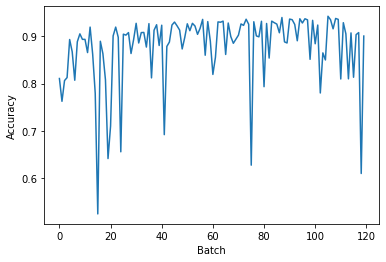

In [35]:
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.plot(acc_scores)

### Plot Performance of each classifier on test data

In [33]:
predictions = classifier.predict(test['data'])
print(classification_report(test['label'], predictions))
print('Percentage correct: ', 100*np.sum(predictions == test['label'])/len(test['label']))

              precision    recall  f1-score   support

      benign       0.90      0.90      0.90      1500
   malicious       0.90      0.91      0.90      1500

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Percentage correct:  90.06666666666666


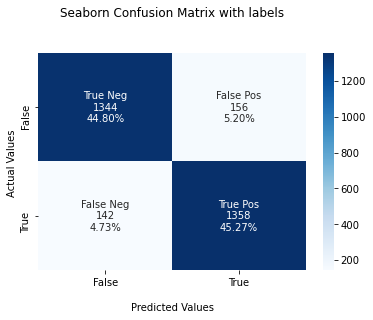

In [36]:
cf_matrix = confusion_matrix(test['label'], predictions)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

C:\Users\test\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


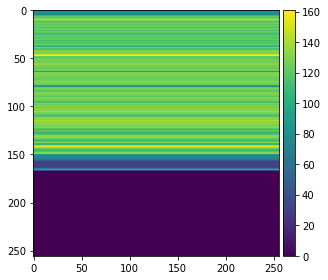

In [37]:
Xi = np.load("F:/test/Downloads/images_256x256/images_256x256/benign/SIV-Iraqi-USG-Guidelines-and-DS-157-Instructions-English.npy").astype('float32')
Xi = skimage.transform.resize(Xi, (256,256)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [38]:
#superpixels = skimage.segmentation.chan_vese(Xi, mu=0.99, lambda1=1.0, lambda2=1.0, tol=0.001, dt=0.5, init_level_set='disk', extended_output=False)
superpixels = skimage.segmentation.felzenszwalb(Xi, scale=5, sigma=0.8, min_size=50)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

173

In [39]:
#skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [40]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0])

In [41]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:]
    return perturbed_image

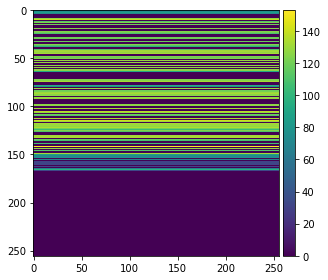

In [42]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [47]:
%%time
%%memit
predictions = []
Xi = np.load("F:/test/Downloads/images_256x256/images_256x256/benign/SIV-Iraqi-USG-Guidelines-and-DS-157-Instructions-English.npy").astype('float32')
Xi = skimage.transform.resize(Xi[1024:], (256,256)) 
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    perturbed_img = skimage.transform.resize(perturbed_img, (1,64512)) 
    pred = classifier.predict(perturbed_img)
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

peak memory: 2011.70 MiB, increment: 0.27 MiB
Wall time: 10.2 s


In [48]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = pairwise_distances(perturbations,original_image, metric='cosine').ravel()

In [49]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function

In [50]:
class_to_explain = ['malicious','benign']
predictions2 = []
for x in predictions:
    predictions2.append(class_to_explain.index(x))
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions2, sample_weight=weights)
#coeff = simpler_model.coef_[0]
coeff = simpler_model.coef_
#coeff  

In [51]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([ 60,  61,  53, 172], dtype=int64)

C:\Users\test\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


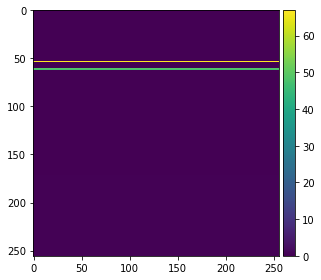

In [52]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )

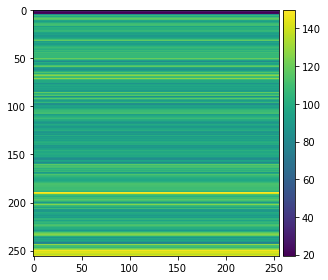

In [53]:
Xi = np.load("F:/test/Downloads/images_256x256/images_256x256/benign/StorageContextHandler.npy").astype('float32')
Xi = skimage.transform.resize(Xi, (256,256)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing


256


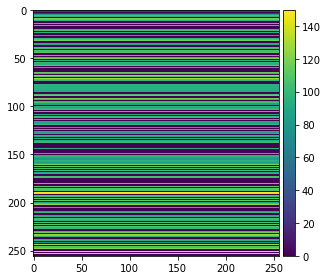

In [54]:
superpixels = skimage.segmentation.felzenszwalb(Xi, scale=5, sigma=0.8, min_size=50)
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

[ 92  93 254 255]


C:\Users\test\anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


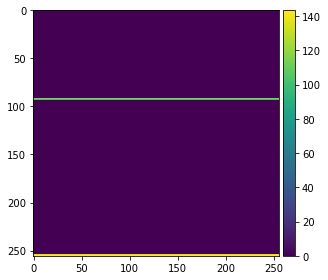

In [55]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi,pert,superpixels)
    perturbed_img = skimage.transform.resize(perturbed_img, (1,64512)) 
    pred = classifier.predict(perturbed_img)
    predictions.append(pred)

predictions = np.array(predictions)

original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = pairwise_distances(perturbations,original_image, metric='cosine').ravel()
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
class_to_explain = ['malicious','benign']
predictions2 = []
for x in predictions:
    predictions2.append(class_to_explain.index(x))
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions2, sample_weight=weights)
coeff = simpler_model.coef_
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
print(top_features)
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )